# Machine Learning for Finance in Python

## Chapter 3

In [61]:
from datetime import datetime
import talib
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import scale
from sklearn.neighbors import KNeighborsRegressor
from keras.models import Sequential
from keras.layers import Dense

import seaborn as sns
from matplotlib import pyplot as plt

ModuleNotFoundError: No module named 'keras'

In [39]:
start_date_string = "2016-04-15"
end_date_string = "2018-04-10"

lng_df_all = pd.read_csv("LNG.csv")
lng_df_all.set_index("Date", inplace=True)
lng_df = lng_df_all.loc[start_date_string:end_date_string].copy()

lng_df.index = pd.to_datetime(lng_df.index)

print(lng_df)

            Adj_Close  Adj_Volume
Date                             
2016-04-15      37.13   4293775.0
2016-04-18      36.90   3445852.0
2016-04-19      37.12   3748050.0
2016-04-20      37.77   2470384.0
2016-04-21      37.21   2043988.0
...               ...         ...
2018-04-04      54.30   1816771.0
2018-04-05      56.21   2533635.0
2018-04-06      54.36   1754446.0
2018-04-09      54.10   1203998.0
2018-04-10      55.63   3430268.0

[500 rows x 2 columns]


In [40]:
# Create 5-day % changes of Adj_Close for the current day, and 5 days in the future
lng_df['5d_future_close'] = lng_df['Adj_Close'].shift(-5)
lng_df['5d_close_future_pct'] = lng_df['5d_future_close'].pct_change(5)
lng_df['5d_close_pct'] = lng_df['Adj_Close'].pct_change(5)

# Calculate the correlation matrix between the 5d close pecentage changes (current and future)
corr = lng_df[['5d_close_pct', '5d_close_future_pct']].corr()
print(corr)

                     5d_close_pct  5d_close_future_pct
5d_close_pct             1.000000            -0.164861
5d_close_future_pct     -0.164861             1.000000


In [41]:
feature_names = ['5d_close_pct']  # a list of the feature names for later

# Create moving averages and rsi for timeperiods of 14, 30, 50, and 200
for n in [14, 30, 50, 200]:

    # Create the moving average indicator and divide by Adj_Close
    lng_df['ma' + str(n)] = talib.SMA(lng_df['Adj_Close'].values,
                              timeperiod=n) / lng_df["Adj_Close"]
    # Create the RSI indicator
    lng_df['rsi' + str(n)] = talib.RSI(lng_df['Adj_Close'].values, timeperiod=n)
    
    # Add rsi and moving average to the feature name list
    feature_names = feature_names + ['ma' + str(n), 'rsi' + str(n)]

print(feature_names)

['5d_close_pct', 'ma14', 'rsi14', 'ma30', 'rsi30', 'ma50', 'rsi50', 'ma200', 'rsi200']


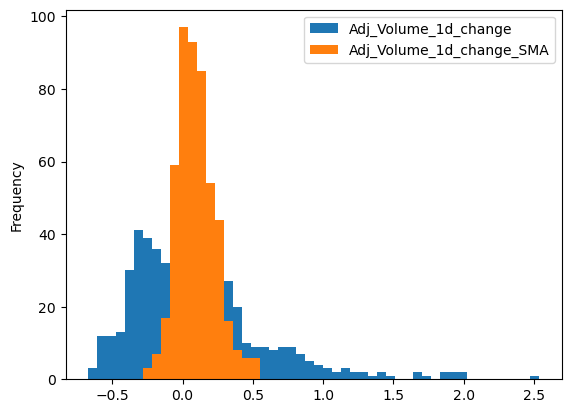

In [42]:
# Create 2 new volume features, 1-day % change and 5-day SMA of the % change
new_features = ['Adj_Volume_1d_change', 'Adj_Volume_1d_change_SMA']
feature_names.extend(new_features)
lng_df["Adj_Volume_1d_change"] = lng_df['Adj_Volume'].pct_change()
lng_df['Adj_Volume_1d_change_SMA'] = talib.SMA(lng_df["Adj_Volume_1d_change"].values,
                        timeperiod=5)

# Plot histogram of volume % change data
lng_df[new_features].plot(kind='hist', sharex=False, bins=50)
plt.show()

In [43]:
# Use pandas' get_dummies function to get dummies for day of the week
days_of_week = pd.get_dummies(lng_df.index.dayofweek,
                              prefix="weekday",
                              drop_first=True,
                              dtype=int)

# Set the index as the original dataframe index for merging
days_of_week.index = lng_df.index

# Join the dataframe with the days of week dataframe
lng_df = pd.concat([lng_df, days_of_week], axis=1)

# Add days of week to feature names
feature_names.extend(['weekday_' + str(i) for i in range(1, 5)])
lng_df.dropna(inplace=True)  # drop missing values in-place

print(lng_df.head())

            Adj_Close  Adj_Volume  5d_future_close  5d_close_future_pct  \
Date                                                                      
2017-01-31      47.65   2137394.0            47.81             0.003358   
2017-02-01      47.10   2051631.0            48.01             0.019321   
2017-02-02      49.33   3081369.0            49.19            -0.002838   
2017-02-03      49.43   4158130.0            48.93            -0.010115   
2017-02-06      48.50   2090909.0            48.14            -0.007423   

            5d_close_pct      ma14      rsi14      ma30      rsi30      ma50  \
Date                                                                           
2017-01-31      0.043812  0.950697  62.968946  0.918657  60.655749  0.895731   
2017-02-01     -0.023429  0.967486  60.156019  0.932427  59.159791  0.910110   
2017-02-02     -0.021618  0.932220  66.659314  0.895486  62.988478  0.873379   
2017-02-03      0.007336  0.938976  66.920059  0.899461  63.148741  0.8754

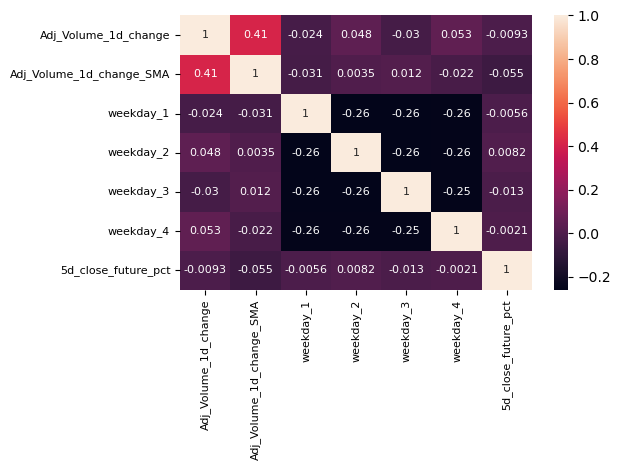

In [44]:
# Add the weekday labels to the new_features list
new_features.extend(['weekday_' + str(i) for i in range(1, 5)])

# Plot the correlations between the new features and the targets
sns.heatmap(lng_df[new_features+ ['5d_close_future_pct']].corr(), annot=True, annot_kws = {"size": 8})
plt.yticks(rotation=0, size = 8)# ensure y-axis ticklabels are horizontal
plt.xticks(rotation=90, size = 8)  # ensure x-axis ticklabels are vertical
plt.tight_layout()
plt.show()

Even though the correlations are weak, they may improve our predictions via interactions with other features.

In [45]:
lng_df

,Adj_Close,Adj_Volume,5d_future_close,5d_close_future_pct,5d_close_pct,ma14,rsi14,ma30,rsi30,ma50,rsi50,ma200,rsi200,Adj_Volume_1d_change,Adj_Volume_1d_change_SMA,weekday_1,weekday_2,weekday_3,weekday_4
Date,,,,,,,,,,,,,,,,,,,
2017-01-31,47.65,2137394.0,47.81,0.003358,0.043812,0.950697,62.968946,0.918657,60.655749,0.895731,57.951677,0.839267,53.695377,-0.175332,-0.000664,1,0,0,0
2017-02-01,47.10,2051631.0,48.01,0.019321,-0.023429,0.967486,60.156019,0.932427,59.159791,0.910110,57.041713,0.850150,53.487663,-0.040125,-0.165783,0,1,0,0
2017-02-02,49.33,3081369.0,49.19,-0.002838,-0.021618,0.932220,66.659314,0.895486,62.988478,0.873379,59.662227,0.812956,54.209475,0.501912,-0.081419,0,0,1,0
2017-02-03,49.43,4158130.0,48.93,-0.010115,0.007336,0.938976,66.920059,0.899461,63.148741,0.875497,59.774509,0.812490,54.241479,0.349442,0.108332,0,0,0,1
2017-02-06,48.50,2090909.0,48.14,-0.007423,0.022129,0.964080,62.059184,0.921608,60.623276,0.895860,58.236185,0.829234,53.889442,-0.497152,0.027749,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-03-27,53.06,1907271.0,54.30,0.023370,0.001510,1.004725,46.112898,1.026354,48.423080,1.041368,50.601497,0.922859,52.446487,-0.048011,0.145910,1,0,0,0
2018-03-28,52.30,1272452.0,56.21,0.074761,-0.033986,1.017058,42.796606,1.038018,46.788195,1.055159,49.525314,0.936544,52.142361,-0.332842,-0.071550,0,1,0,0
2018-03-29,53.45,2756953.0,54.36,0.017025,0.027489,0.994387,48.797185,1.012735,49.459257,1.031622,51.130119,0.916875,52.560707,1.166646,0.180670,0,0,1,0


In [51]:
lng_df_knn = lng_df.iloc[:, :-4].copy()

train_features = lng_df_knn.loc["2017-01-31":"2018-01-26"].copy()
test_features = lng_df_knn.loc["2018-01-27":].copy()

In [57]:
train_features.head()

,Adj_Close,Adj_Volume,5d_future_close,5d_close_future_pct,5d_close_pct,ma14,rsi14,ma30,rsi30,ma50,rsi50,ma200,rsi200,Adj_Volume_1d_change,Adj_Volume_1d_change_SMA
Date,,,,,,,,,,,,,,,
2017-01-31,47.65,2137394.0,47.81,0.003358,0.043812,0.950697,62.968946,0.918657,60.655749,0.895731,57.951677,0.839267,53.695377,-0.175332,-0.000664
2017-02-01,47.10,2051631.0,48.01,0.019321,-0.023429,0.967486,60.156019,0.932427,59.159791,0.910110,57.041713,0.850150,53.487663,-0.040125,-0.165783
2017-02-02,49.33,3081369.0,49.19,-0.002838,-0.021618,0.932220,66.659314,0.895486,62.988478,0.873379,59.662227,0.812956,54.209475,0.501912,-0.081419
2017-02-03,49.43,4158130.0,48.93,-0.010115,0.007336,0.938976,66.920059,0.899461,63.148741,0.875497,59.774509,0.812490,54.241479,0.349442,0.108332
2017-02-06,48.50,2090909.0,48.14,-0.007423,0.022129,0.964080,62.059184,0.921608,60.623276,0.895860,58.236185,0.829234,53.889442,-0.497152,0.027749


In [56]:
test_features.head()

,Adj_Close,Adj_Volume,5d_future_close,5d_close_future_pct,5d_close_pct,ma14,rsi14,ma30,rsi30,ma50,rsi50,ma200,rsi200,Adj_Volume_1d_change,Adj_Volume_1d_change_SMA
Date,,,,,,,,,,,,,,,
2018-01-29,59.04,1354021.0,54.99,-0.068598,0.065896,0.952768,73.932511,0.920715,69.930434,0.877324,65.512999,0.805336,55.824151,-0.369715,0.137488
2018-01-30,56.99,2130060.0,55.50,-0.026145,-0.002974,0.990863,59.561115,0.958051,62.461928,0.911620,61.049948,0.835196,54.897148,0.573137,0.031643
2018-01-31,56.56,1737392.0,55.39,-0.020686,-0.023143,1.001781,57.055799,0.969437,61.047206,0.921135,60.172560,0.842414,54.705641,-0.184346,-0.084660
2018-02-01,57.86,1793786.0,53.15,-0.081403,-0.015819,0.983495,62.228564,0.952368,63.623940,0.903605,61.863379,0.824432,55.180703,0.032459,-0.020966
2018-02-02,56.01,2084715.0,55.57,-0.007856,-0.066344,1.017612,52.531295,0.987830,57.977887,0.936304,58.271099,0.852578,54.365188,0.162187,0.042744


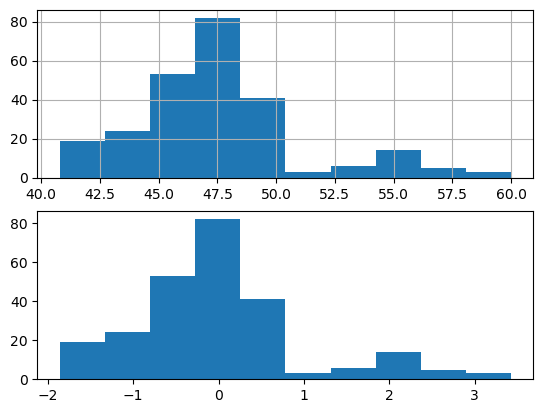

In [58]:
# Standardize the train and test features
scaled_train_features = scale(train_features)
scaled_test_features = scale(test_features)

# Plot histograms of the 14-day SMA RSI before and after scaling
f, ax = plt.subplots(nrows=2, ncols=1)
train_features.iloc[:, 2].hist(ax=ax[0])
ax[1].hist(scaled_train_features[:, 2])
plt.show()           

In [59]:
for n in range(2, 13):
    # Create and fit the KNN model
    knn = KNeighborsRegressor(n_neighbors=n)
    
    # Fit the model to the training data
    knn.fit(scaled_train_features, train_targets)
    
    # Print number of neighbors and the score to find the best value of n
    print("n_neighbors =", n)
    print('train, test scores')
    print(knn.score(scaled_train_features, train_targets))
    print(knn.score(scaled_test_features, test_targets))
    print()  # prints a blank line

n_neighbors = 2
train, test scores
0.9390776683115016
0.6773533948728467

n_neighbors = 3
train, test scores
0.925218731576943
0.660926633299794

n_neighbors = 4
train, test scores
0.90534518577648
0.6442129064568489

n_neighbors = 5
train, test scores
0.8870489257808242
0.6426954571384902

n_neighbors = 6
train, test scores
0.8816844509853636
0.6522371710573545

n_neighbors = 7
train, test scores
0.8633496198766935
0.6713082704626587

n_neighbors = 8
train, test scores
0.8509099650933669
0.6590343940361749

n_neighbors = 9
train, test scores
0.8351364901933793
0.6500443051806303

n_neighbors = 10
train, test scores
0.8164478772561151
0.6352298165237569

n_neighbors = 11
train, test scores
0.8063221405189027
0.625908068607678

n_neighbors = 12
train, test scores
0.7983889938354864
0.6289017233515379



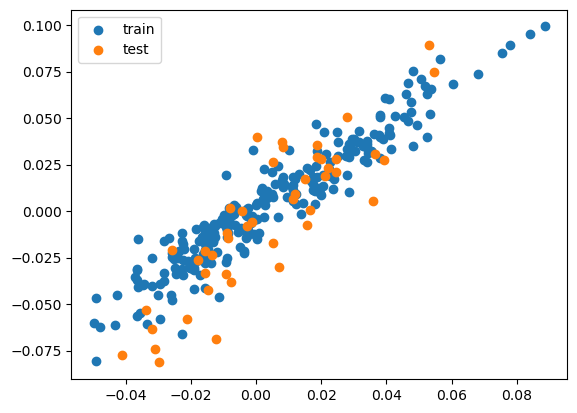

In [60]:
# Create the model with the best-performing n_neighbors of 5
knn = KNeighborsRegressor(n_neighbors = 5)

# Fit the model
knn.fit(scaled_train_features, train_targets)

# Get predictions for train and test sets
train_predictions = knn.predict(scaled_train_features)
test_predictions = knn.predict(scaled_test_features)

# Plot the actual vs predicted values
plt.scatter(train_predictions, train_targets, label='train')
plt.scatter(test_predictions, test_targets, label = "test")
plt.legend()
plt.show()